##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural machine translation with a Transformer and Keras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/transformer">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/transformer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to create and train a [sequence-to-sequence](https://developers.google.com/machine-learning/glossary#sequence-to-sequence-task){:.external} [Transformer](https://developers.google.com/machine-learning/glossary#Transformer){:.external} model to translate [Portuguese into English](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en){:.external}. Most of the components are built with high-level Keras and low-level TensorFlow APIs. The Transformer was originally proposed in ["Attention is all you need"](https://arxiv.org/abs/1706.03762){:.external} by Vaswani et al. (2017).

Transformers are deep neural networks based on [attention](https://developers.google.com/machine-learning/glossary#attention){:.external}. It replaces CNNs and RNNs with [self-attention](https://developers.google.com/machine-learning/glossary#self-attention){:.external}. Attention allows Transformers to access information from distant positions in the input sequence.

As explained in the [Google AI Blog post](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html){:.external}:

> Neural networks for machine translation typically contain an encoder reading the input sentence and generating a representation of it. A decoder then generates the output sentence word by word while consulting the representation generated by the encoder. The Transformer starts by generating initial representations, or embeddings, for each word... Then, using self-attention, it aggregates information from all of the other words, generating a new representation per word informed by the entire context, represented by the filled balls. This step is then repeated multiple times in parallel for all words, successively generating new representations.

<img src="https://www.tensorflow.org/images/tutorials/transformer/apply_the_transformer_to_machine_translation.gif" alt="Applying the Transformer to machine translation">

Figure 1: Applying the Transformer to machine translation. Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).

In this tutorial you will:

- Perpare the data
  - Load the data with [TensorFlow Datasets](https://tensorflow.org/datasets).
  - Define tokenization functions.
  - Build `tf.data` pipelines.
- Implement necessary subcomponents:
  - Positional encoding and [embedding](https://developers.google.com/machine-learning/glossary#embeddings){:.external}.
  - Point-wise feed-forward network.
  - The `EncoderLayer` and `DecoderLayer`
- Assemble these components to define the encoder and decoder.
- Combine the encoder and decoder to build the Transformer.
- Train the Transformer.
- Generate translations.
- Export your model.

To get the most out of this tutorial, it helps if you know about [the basics of text generation](./text_generation.ipynb) and [attention mechanisms](./nmt_with_attention.ipynb).

After training the model in this notebook, you will be able to input a Portuguese sentence and return the English translation.

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" alt="Attention heatmap">

Figure 2: Visualized attention weights that you can generate at the end of this tutorial.

## Why Transformers are significant

- Transformers excel at modeling sequential data, such as natural language.
- Unlike the [recurrent neural networks (RNNs)](./text_generation.ipynb), such as [LSTMs](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.676.4320&rep=rep1&type=pdf){:.external}, Transformers can be more computationally efficient and parallelizable across several specialized hardware, like GPUs and TPUs. One of the main reasons is that Transformers replaced recurrence with attention, and computations can happen simultaneously. Layer outputs can be calculated in parallel, instead of a series like an RNN.
- Unlike [RNNs](https://www.tensorflow.org/guide/keras/rnn) (like [seq2seq, 2014](https://arxiv.org/abs/1409.3215){:.external}) or [convolutional neural networks (CNNs)](https://www.tensorflow.org/tutorials/images/cnn) (for example, [ByteNet](https://arxiv.org/abs/1610.10099){:.external}), Transformers are able to capture distant or long-range contexts and dependencies in the data between distant positions in the input or output sequences. Thus, longer connections can be learned. Attention allows each location to have access to the entire input at each layer, while in RNNs and CNNs, the information needs to pass through many processing steps to move a long distance, which makes it harder to learn.
- Transformers make no assumptions about the temporal/spatial relationships across the data. This is ideal for processing a set of objects (for example, [StarCraft units](https://deepmind.com/blog/alphastar-mastering-real-time-strategy-game-starcraft-ii/#block-8){:.external}).

<img src="https://www.tensorflow.org/images/tutorials/transformer/encoder_self_attention_distribution.png" width="800" alt="Encoder self-attention distribution for the word it from the 5th to the 6th layer of a Transformer trained on English-to-French translation">

Figure 3: The encoder self-attention distribution for the word “it” from the 5th to the 6th layer of a Transformer trained on English-to-French translation (one of eight attention heads). Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).

## Setup

Begin by installing [TensorFlow Datasets](https://tensorflow.org/datasets) for loading the dataset and [TensorFlow Text](https://www.tensorflow.org/text) for text preprocessing:

In [2]:
# Install the nightly version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Import the necessary modules:

In [3]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

2022-09-20 11:10:03.008968: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2022-09-20 11:10:03.656627: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory
2022-09-20 11:10:03.656911: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory
2022-09-20 11:10:03.656924: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Data handling

### Download the dataset

Use TensorFlow Datasets to load the [Portuguese-English translation dataset](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en){:.external} from the TED Talks Open Translation Project. This dataset contains approximately 52,000 training, 1,200 validation and 1,800 test examples.

In [4]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

The `tf.data.Dataset` object returned by TensorFlow Datasets yields pairs of text examples:

In [5]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in Portuguese:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


### Set up the tokenizer

Now that you have loaded the dataset, you need to tokenize the text, so that each element is represented as a [token](https://developers.google.com/machine-learning/glossary#token){:.external} or token ID (a numeric representation).

Tokenization is the process of breaking up a sequence, such as a text, into tokens, for each element in that sequence. Commonly, these tokens are words, characters, numbers, subwords, and/or punctuation. The beginning of sentences and end of sentences are typically also marked by tokens IDs, such as `'[START]'` and `'[END]'`.

Tokenization can be done in various ways. For example, for a text sequence of `'how are you'`, you can apply:

- Word-level tokenization, such as `'how'`, `'are'`, `'you'`.
- Character-level tokenization, such as `'h'`, `'o'`, `'w'`, `'a'`, and so on. This would result in a much longer sequence length compared with the previous method.
- Subword tokenization, which can take care of common/recurring word parts, such as `'ing'` and `'tion'`, as well as common words like `'are'` and `'you'`.

To learn more about tokenization, visit [this guide](https://www.tensorflow.org/text/guide/tokenizers).

This tutorial uses a popular [subword tokenizer](https://www.tensorflow.org/text/guide/subwords_tokenizer) implementation, which builds subword tokenizers (`text.BertTokenizer`) optimized for the dataset and exports them in a TensorFlow `saved_model` format.

Download, extract, and import the `saved_model`:

In [6]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

  8192/184801 [>.............................] - ETA: 0s

184801/184801 [==============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [7]:
tokenizers = tf.saved_model.load(model_name)

The `tf.saved_model` contains two text tokenizers, one for English and one for Portuguese. Both have the same methods:

In [8]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

The `tokenize` method converts a batch of strings to a padded-batch of token IDs. This method splits punctuation, lowercases and unicode-normalizes the input before tokenizing. That standardization is not visible here because the input data is already standardized.

In [9]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [10]:
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


The `detokenize` method attempts to convert these token IDs back to human-readable text: 

In [11]:
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


The lower level `lookup` method converts from token-IDs to token text:

In [12]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

The output demonstrates the "subword" aspect of the subword tokenization.

For example, the word `'searchability'` is decomposed into `'search'` and `'##ability'`, and the word `'serendipity'` into `'s'`, `'##ere'`, `'##nd'`, `'##ip'` and `'##ity'`.

Note that the tokenized text includes `'[START]'` and `'[END]'` tokens.

The distribution of tokens per example in the dataset is as follows:

In [13]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.en.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())
  
  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

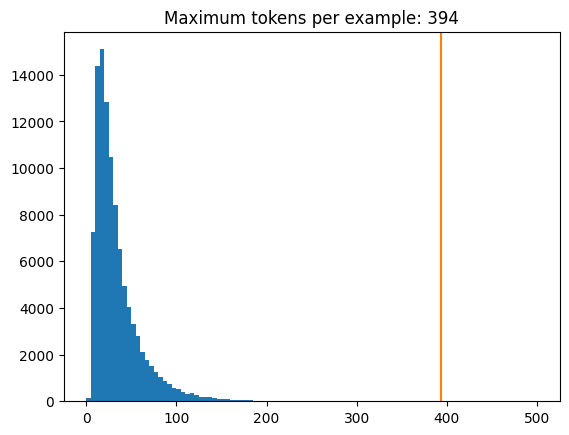

In [14]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

## Set up a data pipeline with `tf.data`

The following function takes batches of text as input, and converts them to a format suitable for training. 

1. It tokenizes them into ragged batches.
2. It trims each to be no longer than `MAX_TOKENS`.
3. It splits the output (English) tokens into inputs and labels. THese shifted by one step so that the `label` at each location is the id of the next token.
4. It converts the `RaggedTensor`s to padded dense `Tensor`s.
5. It returns an `(inputs, labels)` pair.


In [15]:
MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels

The function below converts a dataset of text examples into data of batches for training. 

1. It tokenizes the text, and filters out the sequences that are too long.
   (The `batch`/`unbatch` is included because the tokenizer is much more efficient on large batches).
2. The `cache` method ensures that that work is only executed once.
3. Then `shuffle` and, `dense_to_ragged_batch` randomize the order and assemble batches of examples. 
4. Finally `prefetch` runs the dataset in parallel with the model to ensure that data is available when needed. See [Better performance with the `tf.data`](https://www.tensorflow.org/guide/data_performance.ipynb) for details.

In [16]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [17]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))


# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [18]:
for (pt, en), en_labels in train_batches.take(1):
  print(pt.shape)
  print(en.shape)

(64, 101)
(64, 100)


## Define the components

The Transformer model follows the same general pattern as a standard [sequence-to-sequence](https://www.tensorflow.org/text/tutorials/nmt_with_attention) model with an [encoder](https://developers.google.com/machine-learning/glossary#encoder){:.external} and a [decoder](https://developers.google.com/machine-learning/glossary#decoder){:.external}.

<img src="https://www.tensorflow.org/images/tutorials/transformer/standard_transformer_architecture.png" alt="Standard transformer architecture">

Figure 4: The standard Transformer architecture. The image is from Google Research's ["Efficient Transformers: a survey"](https://arxiv.org/abs/2009.06732){:.external} (Tay et al., 2022).

The ["Attention is all you need"](https://arxiv.org/abs/1706.03762){:.external} paper's authors demonstrated in 2017 that a model made of [self-attention](https://developers.google.com/machine-learning/glossary#self-attention){:.external} layers and feed-forward networks can achieve high translation quality, outperforming [recurrent](https://www.tensorflow.org/text/tutorials/text_classification_rnn) and [convolutional](https://www.tensorflow.org/tutorials/images/cnn) neural networks.

Main similarities and differences between the Transformer and [RNNs with attention](./nmt_with_attention.ipynb):

- In both cases, the model _transforms_ sequences of input embeddings into sequences of output embeddings (which are covered later in this tutorial).
- The decoders generating the output sequences use attention layers to select relevant information from the input sequence.
- To process each sequence—to learn the mapping between inputs and outputs—the [RNNs with attention use RNNs](https://ai.googleblog.com/2016/09/a-neural-network-for-machine.html){:.external}. The Transformer, however, doesn't need RNNs, and relies on the attention layers in both the encoder and the decoder. Self-attention layers with a [residual/skip connection](https://en.wikipedia.org/wiki/Residual_neural_network){:.external} update each location with information selected from the rest of the sequence. Self-attention performs sequence processing by replacing an element with a weighted average of the rest of that sequence.

Read the [Google AI blog post](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html){:.external} for more details.

### Overview

- The input [embeddings](https://developers.google.com/machine-learning/glossary#embeddings){:.external}, added to positional encoding, are passed through the encoder (with N layers) that generates an output for each token in the sequence. This makes sure the model can recognize the word order and helps avoid a [bag-of-words](https://developers.google.com/machine-learning/glossary#bag-of-words){:.external} representation.
  - You will use `tf.keras.layers.Embedding` for the embeddings layers, as well as the `positional_encoding()` function inside the encoder/decoder later in this section.
- The Transformer's encoder and decoder consist of N layers (`num_layers`) each, containing [multi-head attention](https://developers.google.com/machine-learning/glossary#multi-head-self-attention){:.external} (`tf.keras.layers.MultiHeadAttention`) layers with M heads (`num_heads`), and point-wise feed-forward networks.
  - The encoder leverages the self-attention mechanism.
  - The decoder (with N decoder layers) attends to the encoder's output (with cross-attention to utilize the information from the encoder) and its own input (with masked self-attention) to predict the next word. The masked self-attention is causal—it is there to make sure the model can only rely on the preceding tokens in the decoding stage.
  - You will create these Transformer building blocks in this section.

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="Transformer">

Figure 5: The Transformer architecture from Google Research's ["Attention is all you need"](https://arxiv.org/abs/1706.03762){:.external} (Vaswani et al., 2017).

Before creating the encoder and the decoder, start with defining the encoder and decoder layers.

### Define the Embedding and Positional encoding

After converting the texts into sequences of tokens, both the input tokens (Portuguese) and target tokens (English) have to be converted to vectors using a `tf.keras.layers.Embedding` layer.

Attention layers see their input as a set of vectors, with no order. Since the model doesn't contain any recurrent or convolutional layers. It needs some way to identify word order, otherwise it would see the input sequence as aa [bag of words](https://developers.google.com/machine-learning/glossary#bag-of-words){:.external}, where, for instance, `how are you`, `how you are`, `you how are`, and so on, are indestinguishable.

A Transformer adds a "Positional Encoding" to the embedding vectors. It uses a set of sines and cosines at different frequencies (across the sequence). By definition nearby elements will have similar position encodings.

The formula for calculating the positional encoding (implemented in Python below) is as follows:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [19]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  
  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

The position encoding function is a stack of sines and cosines that vibrate at different frequencies depending of their location along the depth of the emvedding vector. They vibrate across the position axis.

(2048, 512)


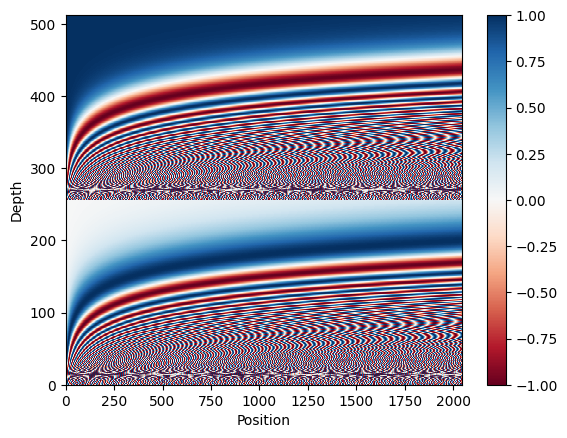

In [20]:
#@title
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

By definition these vectors align well with nearby vectors along the position axis. Below the position encoding vectors are normalized and the vector from position `1000` is compared, by dot-product, to all the others:

(0.0, 1.0)

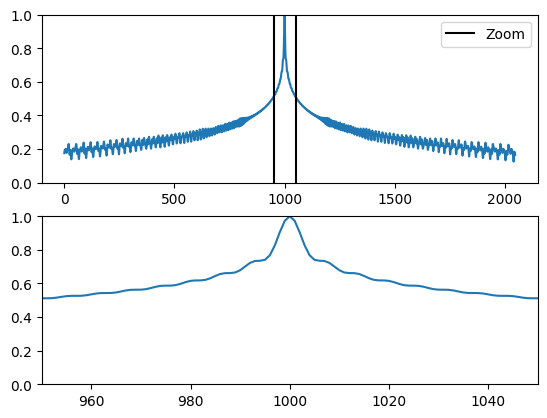

In [21]:
#@title
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])


So use this to create a `PositionEmbedding` layer that looks-up a token's embedding vector and adds the position vector:

In [22]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x


In [23]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

In [24]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 100), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ..., False, False, False]])>

### Define the feed forward network

Define a function for the point-wise feed-forward network that you'll use later.

The network consists of two linear layers (`tf.keras.layers.Dense`) with a ReLU activation in-between:

In [25]:
def point_wise_feed_forward_network(
  d_model, # Input/output dimensionality.
  dff # Inner-layer dimensionality.
  ):

  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # Shape `(batch_size, seq_len, dff)`.
      tf.keras.layers.Dense(d_model)  # Shape `(batch_size, seq_len, d_model)`.
  ])

Test the function:

In [26]:
sample_ffn = point_wise_feed_forward_network(512, 2048)

# Print the shape.
print(sample_ffn(tf.random.uniform((64, 50, 512))).shape)

(64, 50, 512)


### Define the encoder layer

An encoder consists of N layers.

Each of these encoder layer consists of sublayers:

- A multi-head attention layer (with a padding mask), implemented with `tf.keras.layers.MultiHeadAttention`.
- A point-wise feed-forward network with `tf.keras.layers.Dense`.
- Each of these sublayers has a residual/skip connection around it, followed by layer normalization (`tf.keras.layers.LayerNormalization`). Residual connections help in avoiding the vanishing gradient problem in deep networks.

Therefore, the output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis (the dimensionality of the input/output). There are N encoder layers in a Transformer.

Note: Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (`tf.keras.layers.Dense`) layers before the multi-head attention function (`tf.keras.layers.MultiHeadAttention`). Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to ["jointly attend to information from different representation subspaces at different positions"](https://arxiv.org/abs/1706.03762){:.external}. The equation used to calculate the self-attention weights is as follows: $$\Large{Attention(Q, K, V) = softmax_k\left(\frac{QK^T}{\sqrt{d_k}}\right) V} $$

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">

Figure 6: Multi-head attention from Google Research's ["Attention is all you need"](https://arxiv.org/abs/1706.03762){:.external} (Vaswani et al., 2017).

Define the encoder layer by subclassing `tf.keras.layers.Layer`:

In [27]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*,
               d_model, # Input/output dimensionality.
               num_attention_heads,
               dff, # Inner-layer dimensionality.
               dropout_rate=0.1
               ):
    super().__init__()


    # Multi-head self-attention.
    self.mha = tf.keras.layers.MultiHeadAttention(
        num_heads=num_attention_heads,
        key_dim=d_model, # Size of each attention head for query Q and key K.
        dropout=dropout_rate,
        )
    # Point-wise feed-forward network.
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    # Layer normalization.
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    # Dropout for the point-wise feed-forward network.
    self.dropout1 = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x, training, mask):

    # A boolean mask.
    if mask is not None:
      mask1 = mask[:, :, None]
      mask2 = mask[:, None, :]
      attention_mask = mask1 & mask2
    else:
      attention_mask = None

    # Multi-head self-attention output (`tf.keras.layers.MultiHeadAttention `).
    attn_output = self.mha(
        query=x,  # Query Q tensor.
        value=x,  # Value V tensor.
        key=x,  # Key K tensor.
        attention_mask=attention_mask, # A boolean mask that prevents attention to certain positions.
        training=training, # A boolean indicating whether the layer should behave in training mode.
        )

    # Multi-head self-attention output after layer normalization and a residual/skip connection.
    out1 = self.layernorm1(x + attn_output)  # Shape `(batch_size, input_seq_len, d_model)`

    # Point-wise feed-forward network output.
    ffn_output = self.ffn(out1)  # Shape `(batch_size, input_seq_len, d_model)`
    ffn_output = self.dropout1(ffn_output, training=training)
    # Point-wise feed-forward network output after layer normalization and a residual skip connection.
    out2 = self.layernorm2(out1 + ffn_output)  # Shape `(batch_size, input_seq_len, d_model)`.

    return out2

Test the encoder layer:

In [28]:
sample_encoder_layer = EncoderLayer(d_model=512, num_attention_heads=8, dff=2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((2, 3, 512)), training=False, mask=None)

# Print the shape.
print(sample_encoder_layer_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(2, 3, 512)


### Define the encoder

The Transformer encoder consists of:

- Input embeddings (with `tf.keras.layers.Embedding`)
- Positional encoding (with `positional_encoding()`)
- N encoder layers (with `EncoderLayer()`)

As mentioned before, the input (Portuguese) is turned into embeddings, which are added to the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

Define the encoder by extending `tf.keras.layers.Layer`:


In [29]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self,
               *,
               num_layers,
               d_model, # Input/output dimensionality.
               num_attention_heads,
               dff, # Inner-layer dimensionality.
               input_vocab_size, # Input (Portuguese) vocabulary size.
               dropout_rate=0.1
               ):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    # Embeddings + Positional encoding
    self.pos_embedding = PositionalEmbedding(input_vocab_size, d_model)

    # Encoder layers.
    self.enc_layers = [
        EncoderLayer(
          d_model=d_model,
          num_attention_heads=num_attention_heads,
          dff=dff,
          dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    # Dropout.
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  # Masking.
  def compute_mask(self, x, previous_mask=None):
    return self.pos_embedding.compute_mask(x, previous_mask)

  def call(self, x, training):

    seq_len = tf.shape(x)[1]

    # Sum up embeddings and positional encoding.
    mask = self.compute_mask(x)
    x = self.pos_embedding(x)  # Shape `(batch_size, input_seq_len, d_model)`.
    # Add dropout.
    x = self.dropout(x, training=training)

    # N encoder layers.
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # Shape `(batch_size, input_seq_len, d_model)`.

Test the encoder:

In [30]:
# Instantiate the encoder.
sample_encoder = Encoder(
    num_layers=2,
    d_model=512,
    num_attention_heads=8,
    dff=2048,
    input_vocab_size=8500)

# Set the test input.
sample_encoder_output = sample_encoder(pt,
                                       training=False)

# Print the shape.
print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 101)
(64, 101, 512)


### Define the decoder layer

A decoder also consists of N layers. Each of these decoder layer consists of sublayers:

- A masked multi-head attention layer (with a look-ahead mask and a padding mask), implemented with `tf.keras.layers.MultiHeadAttention`.
  - Masked self-attention in the decoder treats only the preceding tokens, but not the future ones, as its context.
  - In `tf.keras.layers.MultiHeadAttention`, set the `use_causal_mask` argument to `True` to apply a causal mask to prevent tokens from attending to future tokens.
- A multi-head attention layer (with a padding mask) (also implemented with `tf.keras.layers.MultiHeadAttention`). V (value) and K (key) receive the encoder output as inputs. Q (query) receives the output from the masked multi-head attention sublayer.
- A point-wise feed-forward network with `tf.keras.layers.Dense`.
- Each of these sublayers has a residual/skip connection around it, followed by layer normalization (`tf.keras.layers.LayerNormalization`).

Therefore, the output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

Note: As demonstrated in Figure 4, as query (Q) receives the output from the decoder's first masked self-attention block, and key (K) receives the encoder output, the attention weights in cross-attention represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next token by looking at the encoder output (via cross-attention) and self-attending to its own output (targets).

Define the decoder layer by subclassing `tf.keras.layers.Layer`:

In [31]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model, # Input/output dimensionality.
               num_attention_heads,
               dff, # Inner-layer dimensionality.
               dropout_rate=0.1
               ):
    super().__init__()

    # Masked multi-head self-attention.
    self.mha_masked = tf.keras.layers.MultiHeadAttention(
        num_heads=num_attention_heads,
        key_dim=d_model, # Size of each attention head for query Q and key K.
        dropout=dropout_rate
    )
    # Multi-head cross-attention.
    self.mha_cross = tf.keras.layers.MultiHeadAttention(
        num_heads=num_attention_heads,
        key_dim=d_model, # Size of each attention head for query Q and key K.
        dropout=dropout_rate
    )

    # Point-wise feed-forward network.
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    # Layer normalization.
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    # Dropout for the point-wise feed-forward network.
    self.dropout1 = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x, mask, enc_output, enc_mask, training):
    # The encoder output shape is `(batch_size, input_seq_len, d_model)`.

    # A boolean mask.
    self_attention_mask = None
    if mask is not None:
      mask1 = mask[:, :, None]
      mask2 = mask[:, None, :]
      self_attention_mask = mask1 & mask2

    # Masked multi-head self-attention output (`tf.keras.layers.MultiHeadAttention`).
    attn_masked, attn_weights_masked = self.mha_masked(
        query=x,
        value=x,
        key=x,
        attention_mask=self_attention_mask,  # A boolean mask that prevents attention to certain positions.
        use_causal_mask=True,  # A boolean to indicate whether to apply a causal mask to prevent tokens from attending to future tokens.
        return_attention_scores=True,  # Shape `(batch_size, target_seq_len, d_model)`.
        training=training  # A boolean indicating whether the layer should behave in training mode.
        )

    # Masked multi-head self-attention output after layer normalization and a residual/skip connection.
    out1 = self.layernorm1(attn_masked + x)

    # A boolean mask.
    attention_mask = None
    if mask is not None and enc_mask is not None:
      mask1 = mask[:, :, None]
      mask2 = enc_mask[:, None, :]
      attention_mask = mask1 & mask2

    # Multi-head cross-attention output (`tf.keras.layers.MultiHeadAttention `).
    attn_cross, attn_weights_cross = self.mha_cross(
        query=out1,
        value=enc_output,
        key=enc_output,
        attention_mask=attention_mask,  # A boolean mask that prevents attention to certain positions.
        return_attention_scores=True,  # Shape `(batch_size, target_seq_len, d_model)`.
        training=training  # A boolean indicating whether the layer should behave in training mode.
    )

    # Multi-head cross-attention output after layer normalization and a residual/skip connection.
    out2 = self.layernorm2(attn_cross + out1)  # (batch_size, target_seq_len, d_model)

    # Point-wise feed-forward network output.
    ffn_output = self.ffn(out2)  # Shape `(batch_size, target_seq_len, d_model)`.
    ffn_output = self.dropout1(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # Shape `(batch_size, target_seq_len, d_model)`.

    return out3, attn_weights_masked, attn_weights_cross

Test the decoder layer:

In [32]:
sample_decoder_layer = DecoderLayer(d_model=512, num_attention_heads=8, dff=2048)

sample_decoder_layer_output, att1, att2 = sample_decoder_layer(
    x=tf.random.uniform((2, 5, 512)),
    mask=None,
    enc_output=sample_encoder_layer_output,
    enc_mask=None,
    training=False)

# Print the shape.
print(sample_decoder_layer_output.shape)  # `(batch_size, target_seq_len, d_model)`

(2, 5, 512)


Having defined the encoder and decoder layers, you can now create the Transformer encoder and decoder, and then build the Transformer model.

### Define the decoder

The Transformer decoder consists of:

- Output embeddings (with `tf.keras.layers.Embedding`)
- Positional encoding (with `positional_encoding()`)
- N decoder layers (with `DecoderLayer`)

The target (English) is turned into embeddings, which are added to the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer, where the prediction is made.

Define the decoder by extending `tf.keras.layers.Layer`:

In [33]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,
               *,
               num_layers,
               d_model, # Input/output dimensionality.
               num_attention_heads,
               dff, # Inner-layer dimensionality.
               target_vocab_size,
               dropout_rate=0.1
               ):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(target_vocab_size, d_model)

    self.dec_layers = [
        DecoderLayer(
          d_model=d_model,
          num_attention_heads=num_attention_heads,
          dff=dff,
          dropout_rate=dropout_rate)
        for _ in range(num_layers)
    ]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x, enc_output, enc_mask, training):
    attention_weights = {}

    mask = self.pos_embedding.compute_mask(x)
    x = self.pos_embedding(x)  # Shape: `(batch_size, target_seq_len, d_model)`.

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2  = self.dec_layers[i](x, mask, enc_output, enc_mask, training)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # The shape of x is `(batch_size, target_seq_len, d_model)`.
    return x, attention_weights

Test the decoder:

In [34]:
# Instantiate the decoder.
sample_decoder = Decoder(
    num_layers=2,
    d_model=512,
    num_attention_heads=8,
    dff=2048,
    target_vocab_size=8000)

# Set the test input.
output, attn = sample_decoder(
    x=en,
    enc_output=sample_encoder_output,
    enc_mask=None,
    training=False)


# Print the shapes.
print(en.shape)
print(output.shape)
print(attn['decoder_layer2_block2'].shape)

(64, 100)
(64, 100, 512)
(64, 8, 100, 101)


Having created the Transformer encoder and decoder, it's time to build the Transformer model and train it.

## Set up the Transformer

You now have `Encoder` and `Decoder`. To complete the Transformer model, you need to put them together and add a final linear (`Dense`) layer. The output of the decoder is the input to the final linear layer.

To recap the architecture:

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

Figure 7: The Transformer architecture from Google Research's ["Attention is all you need"](https://arxiv.org/abs/1706.03762){:.external} (Vaswani et al., 2017).

Create the `Transformer` by extending `tf.keras.Model`:


In [35]:
class Transformer(tf.keras.Model):
  def __init__(self,
               *,
               num_layers, # Number of decoder layers.
               d_model, # Input/output dimensionality.
               num_attention_heads,
               dff, # Inner-layer dimensionality.
               input_vocab_size, # Input (Portuguese) vocabulary size.
               target_vocab_size, # Target (English) vocabulary size.
               dropout_rate=0.1
               ):
    super().__init__()
    # The encoder.
    self.encoder = Encoder(
      num_layers=num_layers,
      d_model=d_model,
      num_attention_heads=num_attention_heads,
      dff=dff,
      input_vocab_size=input_vocab_size,
      dropout_rate=dropout_rate
      )

    # The decoder.
    self.decoder = Decoder(
      num_layers=num_layers,
      d_model=d_model,
      num_attention_heads=num_attention_heads,
      dff=dff,
      target_vocab_size=target_vocab_size,
      dropout_rate=dropout_rate
      )

    # The final linear layer.
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    # Keras models prefer if you pass all your inputs in the first argument.
    # Portuguese is used as the input (`inp`) language.
    # English is the target (`tar`) language.
    inp, tar = inputs

    # The encoder output.
    enc_output = self.encoder(inp, training)  # `(batch_size, inp_seq_len, d_model)`
    enc_mask = self.encoder.compute_mask(inp)

    # The decoder output.
    dec_output, attention_weights = self.decoder(
        tar, enc_output, enc_mask, training)  # `(batch_size, tar_seq_len, d_model)`

    # The final linear layer output.
    final_output = self.final_layer(dec_output)  # Shape `(batch_size, tar_seq_len, target_vocab_size)`.

    # Return the final output and the attention weights.
    return final_output, attention_weights

### Set hyperparameters

To keep this example small and relatively fast, the values for the stack of identical encoder/decoder layers (`num_layers`), the dimensionality of the input/output (`d_model`), and the dimensionality of the inner-layer (`dff`) have been reduced.

The base model described in the original Transformer paper used `num_layers=6`, `d_model=512`, and `dff=2048`.

The number of self-attention heads remains the same (`num_attention_heads=8`).


In [36]:
num_layers = 4
d_model = 128
dff = 512
num_attention_heads = 8
dropout_rate = 0.1

### Try it out

Instantiate the `Transformer` model:

In [37]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_attention_heads=num_attention_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

Test the `Transformer`:

In [38]:
input = tf.constant([[1,2,3, 4, 0, 0, 0]])
target = tf.constant([[1,2,3, 0]])

x, attention = transformer((input, target))

In [39]:
print(x.shape)
print(attention['decoder_layer1_block1'].shape)
print(attention['decoder_layer4_block2'].shape)

(1, 4, 7010)
(1, 8, 4, 4)
(1, 8, 4, 7)


Print the summary of the model:

In [40]:
transformer.summary()

Model: "transformer"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 encoder_1 (Encoder)         multiple                  3632768   


 decoder_1 (Decoder)         multiple                  5647104   


 dense_30 (Dense)            multiple                  904290    


Total params: 10,184,162


Trainable params: 10,184,162


Non-trainable params: 0


_________________________________________________________________


## Training

It's time to prepare the model and start training it.

### Define the optimizer with a custom learning rate scheduler

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer [paper](https://arxiv.org/abs/1706.03762){:.external}.

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [41]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Instantiate the optimizer (in this example it's `tf.keras.optimizers.Adam`):

In [42]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Test the custom learning rate scheduler:

Text(0.5, 0, 'Train Step')

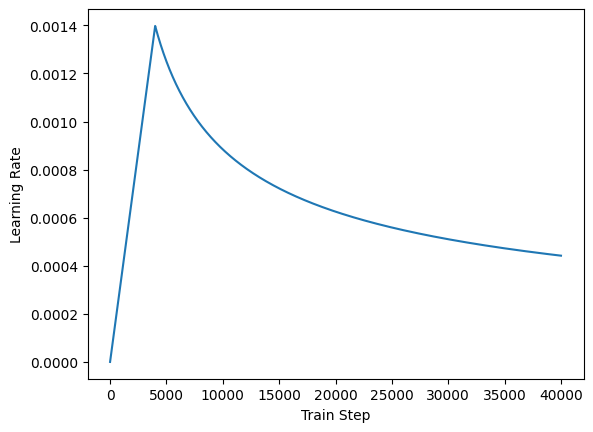

In [43]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

### Define the loss function and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss. Use the cross-entropy loss function (`tf.keras.losses.SparseCategoricalCrossentropy`):

In [44]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [45]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

Set up the metrics:

In [46]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

### Checkpointing

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [47]:
checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# If a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

With the Portuguese-English dataset, Portuguese is used as the input (`inp`) language and English is the target (`tar`) language.

The target is divided into target input (`tar_inp`) and real target (`tar_real`).

- `tar_inp` is passed as an input to the decoder.
- `tar_real` is that same input shifted by `1`: at each location in `tar_input`, `tar_real` contains the next token that should be predicted.

For example, `sentence = 'SOS A lion in the jungle is sleeping EOS'` becomes:

* `tar_inp =  'SOS A lion in the jungle is sleeping'`
* `tar_real = 'A lion in the jungle is sleeping EOS'`

A Transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next.

During training this example uses teacher-forcing (like in the [text generation with RNNs](https://www.tensorflow.org/text/tutorials/text_generation) tutorial). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the model predicts each token, the self-attention mechanism allows it to look at the previous tokens in the input sequence to better predict the next token. As mentioned before, to prevent the model from peeking at the expected output the model uses a look-ahead mask.


### Train the Transformer

Define the training step:

In [48]:
train_step_signature = [
    (
         tf.TensorSpec(shape=(None, None), dtype=tf.int64),
         tf.TensorSpec(shape=(None, None), dtype=tf.int64)),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

# The `@tf.function` trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

@tf.function(input_signature=train_step_signature)
def train_step(inputs, labels):
  (inp, tar_inp) = inputs
  tar_real = labels

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

You can now train the Transformer.

Note: This example model is trained for a few epochs (20) to keep training time reasonable for this tutorial. In Colab with a GPU, it may take around 150 seconds per epoch, or about 50 minutes in total to train the model. To speed things up, you can try reducing the number of `EPOCHS`, which may affect your accuracy.

In [49]:
EPOCHS = 20

In [50]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 8.8824 Accuracy 0.0000


Epoch 1 Batch 50 Loss 8.8082 Accuracy 0.0072


Epoch 1 Batch 100 Loss 8.6891 Accuracy 0.0239


Epoch 1 Batch 150 Loss 8.5670 Accuracy 0.0340


Epoch 1 Batch 200 Loss 8.4175 Accuracy 0.0491


Epoch 1 Batch 250 Loss 8.2402 Accuracy 0.0592


Epoch 1 Batch 300 Loss 8.0452 Accuracy 0.0668


Epoch 1 Batch 350 Loss 7.8455 Accuracy 0.0735


Epoch 1 Batch 400 Loss 7.6571 Accuracy 0.0801


Epoch 1 Batch 450 Loss 7.4872 Accuracy 0.0874


Epoch 1 Batch 500 Loss 7.3353 Accuracy 0.0954


Epoch 1 Batch 550 Loss 7.1951 Accuracy 0.1035


Epoch 1 Batch 600 Loss 7.0632 Accuracy 0.1108


Epoch 1 Batch 650 Loss 6.9402 Accuracy 0.1177


Epoch 1 Batch 700 Loss 6.8249 Accuracy 0.1247


Epoch 1 Batch 750 Loss 6.7189 Accuracy 0.1316


Epoch 1 Batch 800 Loss 6.6189 Accuracy 0.1386


Epoch 1 Loss 6.6027 Accuracy 0.1397
Time taken for 1 epoch: 141.36 secs



Epoch 2 Batch 0 Loss 4.9260 Accuracy 0.2897


Epoch 2 Batch 50 Loss 5.0384 Accuracy 0.2524


Epoch 2 Batch 100 Loss 5.0003 Accuracy 0.2552


Epoch 2 Batch 150 Loss 4.9570 Accuracy 0.2592


Epoch 2 Batch 200 Loss 4.9177 Accuracy 0.2629


Epoch 2 Batch 250 Loss 4.8812 Accuracy 0.2667


Epoch 2 Batch 300 Loss 4.8463 Accuracy 0.2705


Epoch 2 Batch 350 Loss 4.8197 Accuracy 0.2731


Epoch 2 Batch 400 Loss 4.7891 Accuracy 0.2761


Epoch 2 Batch 450 Loss 4.7565 Accuracy 0.2795


Epoch 2 Batch 500 Loss 4.7234 Accuracy 0.2830


Epoch 2 Batch 550 Loss 4.6970 Accuracy 0.2861


Epoch 2 Batch 600 Loss 4.6706 Accuracy 0.2888


Epoch 2 Batch 650 Loss 4.6449 Accuracy 0.2917


Epoch 2 Batch 700 Loss 4.6158 Accuracy 0.2949


Epoch 2 Batch 750 Loss 4.5921 Accuracy 0.2974


Epoch 2 Batch 800 Loss 4.5676 Accuracy 0.2999


Epoch 2 Loss 4.5622 Accuracy 0.3005
Time taken for 1 epoch: 131.64 secs



Epoch 3 Batch 0 Loss 3.9077 Accuracy 0.3821


Epoch 3 Batch 50 Loss 4.1100 Accuracy 0.3507


Epoch 3 Batch 100 Loss 4.0764 Accuracy 0.3528


Epoch 3 Batch 150 Loss 4.0632 Accuracy 0.3539


Epoch 3 Batch 200 Loss 4.0371 Accuracy 0.3567


Epoch 3 Batch 250 Loss 4.0158 Accuracy 0.3589


Epoch 3 Batch 300 Loss 4.0035 Accuracy 0.3601


Epoch 3 Batch 350 Loss 3.9825 Accuracy 0.3627


Epoch 3 Batch 400 Loss 3.9624 Accuracy 0.3648


Epoch 3 Batch 450 Loss 3.9439 Accuracy 0.3668


Epoch 3 Batch 500 Loss 3.9229 Accuracy 0.3691


Epoch 3 Batch 550 Loss 3.9052 Accuracy 0.3711


Epoch 3 Batch 600 Loss 3.8892 Accuracy 0.3729


Epoch 3 Batch 650 Loss 3.8713 Accuracy 0.3751


Epoch 3 Batch 700 Loss 3.8558 Accuracy 0.3767


Epoch 3 Batch 750 Loss 3.8366 Accuracy 0.3789


Epoch 3 Batch 800 Loss 3.8221 Accuracy 0.3805


Epoch 3 Loss 3.8203 Accuracy 0.3807
Time taken for 1 epoch: 131.20 secs



Epoch 4 Batch 0 Loss 3.5908 Accuracy 0.3927


Epoch 4 Batch 50 Loss 3.4928 Accuracy 0.4128


Epoch 4 Batch 100 Loss 3.4703 Accuracy 0.4153


Epoch 4 Batch 150 Loss 3.4563 Accuracy 0.4176


Epoch 4 Batch 200 Loss 3.4427 Accuracy 0.4190


Epoch 4 Batch 250 Loss 3.4265 Accuracy 0.4215


Epoch 4 Batch 300 Loss 3.4099 Accuracy 0.4235


Epoch 4 Batch 350 Loss 3.3929 Accuracy 0.4252


Epoch 4 Batch 400 Loss 3.3811 Accuracy 0.4267


Epoch 4 Batch 450 Loss 3.3695 Accuracy 0.4282


Epoch 4 Batch 500 Loss 3.3603 Accuracy 0.4291


Epoch 4 Batch 550 Loss 3.3506 Accuracy 0.4303


Epoch 4 Batch 600 Loss 3.3370 Accuracy 0.4320


Epoch 4 Batch 650 Loss 3.3254 Accuracy 0.4336


Epoch 4 Batch 700 Loss 3.3115 Accuracy 0.4355


Epoch 4 Batch 750 Loss 3.2969 Accuracy 0.4373


Epoch 4 Batch 800 Loss 3.2866 Accuracy 0.4385


Epoch 4 Loss 3.2838 Accuracy 0.4389
Time taken for 1 epoch: 131.16 secs



Epoch 5 Batch 0 Loss 2.9243 Accuracy 0.4822


Epoch 5 Batch 50 Loss 3.0087 Accuracy 0.4680


Epoch 5 Batch 100 Loss 2.9811 Accuracy 0.4718


Epoch 5 Batch 150 Loss 2.9764 Accuracy 0.4729


Epoch 5 Batch 200 Loss 2.9649 Accuracy 0.4740


Epoch 5 Batch 250 Loss 2.9557 Accuracy 0.4754


Epoch 5 Batch 300 Loss 2.9457 Accuracy 0.4765


Epoch 5 Batch 350 Loss 2.9392 Accuracy 0.4771


Epoch 5 Batch 400 Loss 2.9352 Accuracy 0.4774


Epoch 5 Batch 450 Loss 2.9271 Accuracy 0.4786


Epoch 5 Batch 500 Loss 2.9178 Accuracy 0.4796


Epoch 5 Batch 550 Loss 2.9092 Accuracy 0.4807


Epoch 5 Batch 600 Loss 2.9043 Accuracy 0.4812


Epoch 5 Batch 650 Loss 2.8966 Accuracy 0.4823


Epoch 5 Batch 700 Loss 2.8922 Accuracy 0.4830


Epoch 5 Batch 750 Loss 2.8889 Accuracy 0.4834


Epoch 5 Batch 800 Loss 2.8825 Accuracy 0.4844


Saving checkpoint for epoch 5 at ./checkpoints/train/ckpt-1
Epoch 5 Loss 2.8820 Accuracy 0.4845
Time taken for 1 epoch: 132.31 secs



Epoch 6 Batch 0 Loss 2.7628 Accuracy 0.4893


Epoch 6 Batch 50 Loss 2.6753 Accuracy 0.5049


Epoch 6 Batch 100 Loss 2.6326 Accuracy 0.5110


Epoch 6 Batch 150 Loss 2.6390 Accuracy 0.5106


Epoch 6 Batch 200 Loss 2.6360 Accuracy 0.5112


Epoch 6 Batch 250 Loss 2.6291 Accuracy 0.5127


Epoch 6 Batch 300 Loss 2.6228 Accuracy 0.5140


Epoch 6 Batch 350 Loss 2.6164 Accuracy 0.5151


Epoch 6 Batch 400 Loss 2.6142 Accuracy 0.5155


Epoch 6 Batch 450 Loss 2.6052 Accuracy 0.5167


Epoch 6 Batch 500 Loss 2.5980 Accuracy 0.5179


Epoch 6 Batch 550 Loss 2.5933 Accuracy 0.5184


Epoch 6 Batch 600 Loss 2.5867 Accuracy 0.5193


Epoch 6 Batch 650 Loss 2.5823 Accuracy 0.5198


Epoch 6 Batch 700 Loss 2.5785 Accuracy 0.5203


Epoch 6 Batch 750 Loss 2.5729 Accuracy 0.5211


Epoch 6 Batch 800 Loss 2.5687 Accuracy 0.5217


Epoch 6 Loss 2.5678 Accuracy 0.5219
Time taken for 1 epoch: 131.64 secs



Epoch 7 Batch 0 Loss 2.3590 Accuracy 0.5447


Epoch 7 Batch 50 Loss 2.2977 Accuracy 0.5559


Epoch 7 Batch 100 Loss 2.3097 Accuracy 0.5548


Epoch 7 Batch 150 Loss 2.3044 Accuracy 0.5544


Epoch 7 Batch 200 Loss 2.3214 Accuracy 0.5522


Epoch 7 Batch 250 Loss 2.3220 Accuracy 0.5528


Epoch 7 Batch 300 Loss 2.3161 Accuracy 0.5534


Epoch 7 Batch 350 Loss 2.3166 Accuracy 0.5532


Epoch 7 Batch 400 Loss 2.3170 Accuracy 0.5534


Epoch 7 Batch 450 Loss 2.3176 Accuracy 0.5534


Epoch 7 Batch 500 Loss 2.3129 Accuracy 0.5540


Epoch 7 Batch 550 Loss 2.3112 Accuracy 0.5543


Epoch 7 Batch 600 Loss 2.3114 Accuracy 0.5540


Epoch 7 Batch 650 Loss 2.3080 Accuracy 0.5545


Epoch 7 Batch 700 Loss 2.3060 Accuracy 0.5550


Epoch 7 Batch 750 Loss 2.3049 Accuracy 0.5553


Epoch 7 Batch 800 Loss 2.3033 Accuracy 0.5557


Epoch 7 Loss 2.3038 Accuracy 0.5555
Time taken for 1 epoch: 131.04 secs



Epoch 8 Batch 0 Loss 2.0603 Accuracy 0.5856


Epoch 8 Batch 50 Loss 2.1192 Accuracy 0.5790


Epoch 8 Batch 100 Loss 2.1092 Accuracy 0.5807


Epoch 8 Batch 150 Loss 2.1134 Accuracy 0.5810


Epoch 8 Batch 200 Loss 2.1163 Accuracy 0.5803


Epoch 8 Batch 250 Loss 2.1214 Accuracy 0.5794


Epoch 8 Batch 300 Loss 2.1201 Accuracy 0.5794


Epoch 8 Batch 350 Loss 2.1222 Accuracy 0.5792


Epoch 8 Batch 400 Loss 2.1246 Accuracy 0.5786


Epoch 8 Batch 450 Loss 2.1224 Accuracy 0.5790


Epoch 8 Batch 500 Loss 2.1197 Accuracy 0.5796


Epoch 8 Batch 550 Loss 2.1204 Accuracy 0.5796


Epoch 8 Batch 600 Loss 2.1207 Accuracy 0.5798


Epoch 8 Batch 650 Loss 2.1188 Accuracy 0.5802


Epoch 8 Batch 700 Loss 2.1154 Accuracy 0.5809


Epoch 8 Batch 750 Loss 2.1155 Accuracy 0.5809


Epoch 8 Batch 800 Loss 2.1156 Accuracy 0.5809


Epoch 8 Loss 2.1161 Accuracy 0.5808
Time taken for 1 epoch: 131.61 secs



Epoch 9 Batch 0 Loss 1.8694 Accuracy 0.6158


Epoch 9 Batch 50 Loss 1.9440 Accuracy 0.6050


Epoch 9 Batch 100 Loss 1.9392 Accuracy 0.6049


Epoch 9 Batch 150 Loss 1.9471 Accuracy 0.6039


Epoch 9 Batch 200 Loss 1.9564 Accuracy 0.6022


Epoch 9 Batch 250 Loss 1.9654 Accuracy 0.6013


Epoch 9 Batch 300 Loss 1.9633 Accuracy 0.6013


Epoch 9 Batch 350 Loss 1.9641 Accuracy 0.6011


Epoch 9 Batch 400 Loss 1.9668 Accuracy 0.6007


Epoch 9 Batch 450 Loss 1.9670 Accuracy 0.6008


Epoch 9 Batch 500 Loss 1.9629 Accuracy 0.6014


Epoch 9 Batch 550 Loss 1.9618 Accuracy 0.6016


Epoch 9 Batch 600 Loss 1.9627 Accuracy 0.6014


Epoch 9 Batch 650 Loss 1.9651 Accuracy 0.6014


Epoch 9 Batch 700 Loss 1.9656 Accuracy 0.6012


Epoch 9 Batch 750 Loss 1.9665 Accuracy 0.6013


Epoch 9 Batch 800 Loss 1.9675 Accuracy 0.6013


Epoch 9 Loss 1.9679 Accuracy 0.6013
Time taken for 1 epoch: 131.25 secs



Epoch 10 Batch 0 Loss 1.7781 Accuracy 0.6464


Epoch 10 Batch 50 Loss 1.8173 Accuracy 0.6215


Epoch 10 Batch 100 Loss 1.8156 Accuracy 0.6225


Epoch 10 Batch 150 Loss 1.8233 Accuracy 0.6218


Epoch 10 Batch 200 Loss 1.8274 Accuracy 0.6212


Epoch 10 Batch 250 Loss 1.8326 Accuracy 0.6204


Epoch 10 Batch 300 Loss 1.8367 Accuracy 0.6198


Epoch 10 Batch 350 Loss 1.8352 Accuracy 0.6202


Epoch 10 Batch 400 Loss 1.8377 Accuracy 0.6199


Epoch 10 Batch 450 Loss 1.8377 Accuracy 0.6199


Epoch 10 Batch 500 Loss 1.8405 Accuracy 0.6193


Epoch 10 Batch 550 Loss 1.8411 Accuracy 0.6190


Epoch 10 Batch 600 Loss 1.8428 Accuracy 0.6191


Epoch 10 Batch 650 Loss 1.8433 Accuracy 0.6192


Epoch 10 Batch 700 Loss 1.8449 Accuracy 0.6189


Epoch 10 Batch 750 Loss 1.8473 Accuracy 0.6188


Epoch 10 Batch 800 Loss 1.8486 Accuracy 0.6187


Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-2
Epoch 10 Loss 1.8493 Accuracy 0.6187
Time taken for 1 epoch: 131.21 secs



Epoch 11 Batch 0 Loss 1.6796 Accuracy 0.6436


Epoch 11 Batch 50 Loss 1.7604 Accuracy 0.6276


Epoch 11 Batch 100 Loss 1.7341 Accuracy 0.6332


Epoch 11 Batch 150 Loss 1.7375 Accuracy 0.6329


Epoch 11 Batch 200 Loss 1.7382 Accuracy 0.6330


Epoch 11 Batch 250 Loss 1.7410 Accuracy 0.6329


Epoch 11 Batch 300 Loss 1.7404 Accuracy 0.6331


Epoch 11 Batch 350 Loss 1.7430 Accuracy 0.6327


Epoch 11 Batch 400 Loss 1.7388 Accuracy 0.6335


Epoch 11 Batch 450 Loss 1.7390 Accuracy 0.6336


Epoch 11 Batch 500 Loss 1.7413 Accuracy 0.6333


Epoch 11 Batch 550 Loss 1.7424 Accuracy 0.6331


Epoch 11 Batch 600 Loss 1.7428 Accuracy 0.6331


Epoch 11 Batch 650 Loss 1.7475 Accuracy 0.6325


Epoch 11 Batch 700 Loss 1.7478 Accuracy 0.6327


Epoch 11 Batch 750 Loss 1.7480 Accuracy 0.6328


Epoch 11 Batch 800 Loss 1.7506 Accuracy 0.6327


Epoch 11 Loss 1.7513 Accuracy 0.6326
Time taken for 1 epoch: 131.47 secs



Epoch 12 Batch 0 Loss 1.5471 Accuracy 0.6642


Epoch 12 Batch 50 Loss 1.6307 Accuracy 0.6525


Epoch 12 Batch 100 Loss 1.6231 Accuracy 0.6526


Epoch 12 Batch 150 Loss 1.6283 Accuracy 0.6515


Epoch 12 Batch 200 Loss 1.6379 Accuracy 0.6497


Epoch 12 Batch 250 Loss 1.6415 Accuracy 0.6489


Epoch 12 Batch 300 Loss 1.6457 Accuracy 0.6481


Epoch 12 Batch 350 Loss 1.6467 Accuracy 0.6478


Epoch 12 Batch 400 Loss 1.6454 Accuracy 0.6482


Epoch 12 Batch 450 Loss 1.6480 Accuracy 0.6477


Epoch 12 Batch 500 Loss 1.6508 Accuracy 0.6473


Epoch 12 Batch 550 Loss 1.6519 Accuracy 0.6472


Epoch 12 Batch 600 Loss 1.6548 Accuracy 0.6470


Epoch 12 Batch 650 Loss 1.6569 Accuracy 0.6467


Epoch 12 Batch 700 Loss 1.6605 Accuracy 0.6463


Epoch 12 Batch 750 Loss 1.6642 Accuracy 0.6457


Epoch 12 Batch 800 Loss 1.6673 Accuracy 0.6453


Epoch 12 Loss 1.6682 Accuracy 0.6451
Time taken for 1 epoch: 130.77 secs



Epoch 13 Batch 0 Loss 1.5085 Accuracy 0.6768


Epoch 13 Batch 50 Loss 1.5652 Accuracy 0.6600


Epoch 13 Batch 100 Loss 1.5657 Accuracy 0.6597


Epoch 13 Batch 150 Loss 1.5612 Accuracy 0.6606


Epoch 13 Batch 200 Loss 1.5601 Accuracy 0.6608


Epoch 13 Batch 250 Loss 1.5665 Accuracy 0.6599


Epoch 13 Batch 300 Loss 1.5719 Accuracy 0.6593


Epoch 13 Batch 350 Loss 1.5723 Accuracy 0.6592


Epoch 13 Batch 400 Loss 1.5746 Accuracy 0.6592


Epoch 13 Batch 450 Loss 1.5755 Accuracy 0.6588


Epoch 13 Batch 500 Loss 1.5765 Accuracy 0.6586


Epoch 13 Batch 550 Loss 1.5820 Accuracy 0.6576


Epoch 13 Batch 600 Loss 1.5831 Accuracy 0.6577


Epoch 13 Batch 650 Loss 1.5870 Accuracy 0.6571


Epoch 13 Batch 700 Loss 1.5891 Accuracy 0.6568


Epoch 13 Batch 750 Loss 1.5904 Accuracy 0.6568


Epoch 13 Batch 800 Loss 1.5930 Accuracy 0.6565


Epoch 13 Loss 1.5929 Accuracy 0.6565
Time taken for 1 epoch: 131.76 secs



Epoch 14 Batch 0 Loss 1.6473 Accuracy 0.6430


Epoch 14 Batch 50 Loss 1.4974 Accuracy 0.6715


Epoch 14 Batch 100 Loss 1.4927 Accuracy 0.6725


Epoch 14 Batch 150 Loss 1.4953 Accuracy 0.6720


Epoch 14 Batch 200 Loss 1.4990 Accuracy 0.6710


Epoch 14 Batch 250 Loss 1.5000 Accuracy 0.6710


Epoch 14 Batch 300 Loss 1.5012 Accuracy 0.6710


Epoch 14 Batch 350 Loss 1.5063 Accuracy 0.6700


Epoch 14 Batch 400 Loss 1.5128 Accuracy 0.6687


Epoch 14 Batch 450 Loss 1.5156 Accuracy 0.6684


Epoch 14 Batch 500 Loss 1.5160 Accuracy 0.6682


Epoch 14 Batch 550 Loss 1.5160 Accuracy 0.6682


Epoch 14 Batch 600 Loss 1.5165 Accuracy 0.6683


Epoch 14 Batch 650 Loss 1.5201 Accuracy 0.6678


Epoch 14 Batch 700 Loss 1.5244 Accuracy 0.6671


Epoch 14 Batch 750 Loss 1.5290 Accuracy 0.6665


Epoch 14 Batch 800 Loss 1.5320 Accuracy 0.6661


Epoch 14 Loss 1.5307 Accuracy 0.6664
Time taken for 1 epoch: 132.13 secs



Epoch 15 Batch 0 Loss 1.2446 Accuracy 0.7165


Epoch 15 Batch 50 Loss 1.4273 Accuracy 0.6842


Epoch 15 Batch 100 Loss 1.4328 Accuracy 0.6826


Epoch 15 Batch 150 Loss 1.4323 Accuracy 0.6823


Epoch 15 Batch 200 Loss 1.4377 Accuracy 0.6813


Epoch 15 Batch 250 Loss 1.4455 Accuracy 0.6799


Epoch 15 Batch 300 Loss 1.4467 Accuracy 0.6795


Epoch 15 Batch 350 Loss 1.4513 Accuracy 0.6790


Epoch 15 Batch 400 Loss 1.4530 Accuracy 0.6786


Epoch 15 Batch 450 Loss 1.4575 Accuracy 0.6776


Epoch 15 Batch 500 Loss 1.4571 Accuracy 0.6779


Epoch 15 Batch 550 Loss 1.4582 Accuracy 0.6776


Epoch 15 Batch 600 Loss 1.4598 Accuracy 0.6775


Epoch 15 Batch 650 Loss 1.4627 Accuracy 0.6770


Epoch 15 Batch 700 Loss 1.4636 Accuracy 0.6770


Epoch 15 Batch 750 Loss 1.4682 Accuracy 0.6764


Epoch 15 Batch 800 Loss 1.4724 Accuracy 0.6756


Saving checkpoint for epoch 15 at ./checkpoints/train/ckpt-3
Epoch 15 Loss 1.4730 Accuracy 0.6755
Time taken for 1 epoch: 131.73 secs



Epoch 16 Batch 0 Loss 1.3207 Accuracy 0.6997


Epoch 16 Batch 50 Loss 1.3757 Accuracy 0.6897


Epoch 16 Batch 100 Loss 1.3775 Accuracy 0.6894


Epoch 16 Batch 150 Loss 1.3830 Accuracy 0.6888


Epoch 16 Batch 200 Loss 1.3873 Accuracy 0.6879


Epoch 16 Batch 250 Loss 1.3925 Accuracy 0.6877


Epoch 16 Batch 300 Loss 1.3942 Accuracy 0.6874


Epoch 16 Batch 350 Loss 1.3998 Accuracy 0.6863


Epoch 16 Batch 400 Loss 1.4021 Accuracy 0.6859


Epoch 16 Batch 450 Loss 1.4020 Accuracy 0.6859


Epoch 16 Batch 500 Loss 1.4034 Accuracy 0.6858


Epoch 16 Batch 550 Loss 1.4067 Accuracy 0.6854


Epoch 16 Batch 600 Loss 1.4100 Accuracy 0.6850


Epoch 16 Batch 650 Loss 1.4112 Accuracy 0.6849


Epoch 16 Batch 700 Loss 1.4141 Accuracy 0.6845


Epoch 16 Batch 750 Loss 1.4162 Accuracy 0.6842


Epoch 16 Batch 800 Loss 1.4203 Accuracy 0.6836


Epoch 16 Loss 1.4209 Accuracy 0.6834
Time taken for 1 epoch: 131.12 secs



Epoch 17 Batch 0 Loss 1.3295 Accuracy 0.7073


Epoch 17 Batch 50 Loss 1.3282 Accuracy 0.6997


Epoch 17 Batch 100 Loss 1.3190 Accuracy 0.7013


Epoch 17 Batch 150 Loss 1.3295 Accuracy 0.6994


Epoch 17 Batch 200 Loss 1.3356 Accuracy 0.6984


Epoch 17 Batch 250 Loss 1.3393 Accuracy 0.6978


Epoch 17 Batch 300 Loss 1.3459 Accuracy 0.6965


Epoch 17 Batch 350 Loss 1.3488 Accuracy 0.6962


Epoch 17 Batch 400 Loss 1.3507 Accuracy 0.6954


Epoch 17 Batch 450 Loss 1.3527 Accuracy 0.6950


Epoch 17 Batch 500 Loss 1.3567 Accuracy 0.6943


Epoch 17 Batch 550 Loss 1.3593 Accuracy 0.6937


Epoch 17 Batch 600 Loss 1.3610 Accuracy 0.6934


Epoch 17 Batch 650 Loss 1.3650 Accuracy 0.6928


Epoch 17 Batch 700 Loss 1.3686 Accuracy 0.6922


Epoch 17 Batch 750 Loss 1.3719 Accuracy 0.6917


Epoch 17 Batch 800 Loss 1.3749 Accuracy 0.6911


Epoch 17 Loss 1.3762 Accuracy 0.6910
Time taken for 1 epoch: 131.86 secs



Epoch 18 Batch 0 Loss 1.2637 Accuracy 0.7007


Epoch 18 Batch 50 Loss 1.2740 Accuracy 0.7108


Epoch 18 Batch 100 Loss 1.2823 Accuracy 0.7070


Epoch 18 Batch 150 Loss 1.2888 Accuracy 0.7062


Epoch 18 Batch 200 Loss 1.2991 Accuracy 0.7044


Epoch 18 Batch 250 Loss 1.2953 Accuracy 0.7049


Epoch 18 Batch 300 Loss 1.3004 Accuracy 0.7040


Epoch 18 Batch 350 Loss 1.3024 Accuracy 0.7033


Epoch 18 Batch 400 Loss 1.3073 Accuracy 0.7024


Epoch 18 Batch 450 Loss 1.3110 Accuracy 0.7018


Epoch 18 Batch 500 Loss 1.3138 Accuracy 0.7014


Epoch 18 Batch 550 Loss 1.3143 Accuracy 0.7014


Epoch 18 Batch 600 Loss 1.3190 Accuracy 0.7004


Epoch 18 Batch 650 Loss 1.3209 Accuracy 0.7002


Epoch 18 Batch 700 Loss 1.3231 Accuracy 0.6997


Epoch 18 Batch 750 Loss 1.3266 Accuracy 0.6992


Epoch 18 Batch 800 Loss 1.3308 Accuracy 0.6985


Epoch 18 Loss 1.3315 Accuracy 0.6983
Time taken for 1 epoch: 132.11 secs



Epoch 19 Batch 0 Loss 1.2233 Accuracy 0.7023


Epoch 19 Batch 50 Loss 1.2470 Accuracy 0.7116


Epoch 19 Batch 100 Loss 1.2431 Accuracy 0.7134


Epoch 19 Batch 150 Loss 1.2407 Accuracy 0.7136


Epoch 19 Batch 200 Loss 1.2535 Accuracy 0.7115


Epoch 19 Batch 250 Loss 1.2612 Accuracy 0.7100


Epoch 19 Batch 300 Loss 1.2603 Accuracy 0.7099


Epoch 19 Batch 350 Loss 1.2630 Accuracy 0.7097


Epoch 19 Batch 400 Loss 1.2664 Accuracy 0.7092


Epoch 19 Batch 450 Loss 1.2705 Accuracy 0.7084


Epoch 19 Batch 500 Loss 1.2735 Accuracy 0.7080


Epoch 19 Batch 550 Loss 1.2765 Accuracy 0.7075


Epoch 19 Batch 600 Loss 1.2797 Accuracy 0.7070


Epoch 19 Batch 650 Loss 1.2824 Accuracy 0.7063


Epoch 19 Batch 700 Loss 1.2863 Accuracy 0.7055


Epoch 19 Batch 750 Loss 1.2901 Accuracy 0.7047


Epoch 19 Batch 800 Loss 1.2935 Accuracy 0.7042


Epoch 19 Loss 1.2945 Accuracy 0.7039
Time taken for 1 epoch: 131.39 secs



Epoch 20 Batch 0 Loss 1.2895 Accuracy 0.7061


Epoch 20 Batch 50 Loss 1.1891 Accuracy 0.7217


Epoch 20 Batch 100 Loss 1.2027 Accuracy 0.7197


Epoch 20 Batch 150 Loss 1.2102 Accuracy 0.7182


Epoch 20 Batch 200 Loss 1.2208 Accuracy 0.7159


Epoch 20 Batch 250 Loss 1.2238 Accuracy 0.7156


Epoch 20 Batch 300 Loss 1.2287 Accuracy 0.7149


Epoch 20 Batch 350 Loss 1.2313 Accuracy 0.7143


Epoch 20 Batch 400 Loss 1.2350 Accuracy 0.7138


Epoch 20 Batch 450 Loss 1.2372 Accuracy 0.7134


Epoch 20 Batch 500 Loss 1.2395 Accuracy 0.7130


Epoch 20 Batch 550 Loss 1.2410 Accuracy 0.7128


Epoch 20 Batch 600 Loss 1.2441 Accuracy 0.7120


Epoch 20 Batch 650 Loss 1.2471 Accuracy 0.7115


Epoch 20 Batch 700 Loss 1.2516 Accuracy 0.7107


Epoch 20 Batch 750 Loss 1.2548 Accuracy 0.7103


Epoch 20 Batch 800 Loss 1.2568 Accuracy 0.7101


Saving checkpoint for epoch 20 at ./checkpoints/train/ckpt-4
Epoch 20 Loss 1.2578 Accuracy 0.7100
Time taken for 1 epoch: 131.97 secs



## Run inference

You can now test the model by performing a translation. The following steps are used for inference:

* Encode the input sentence using the Portuguese tokenizer (`tokenizers.pt`). This is the encoder input.
* The decoder input is initialized to the `[START]` token.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Concatenate the predicted token to the decoder input and pass it to the decoder.
* In this approach, the decoder predicts the next token based on the previous tokens it predicted.

Note: The model is optimized for _efficient training_ and makes a next-token prediction for each token in the output simultaneously. This is redundant during inference, and only the last prediction is used.  This model can be made more efficient for inference if you only calculate the last prediction when running in inference mode (`training=False`).

Define the `Translator` class by subclassing `tf.Module`:

In [51]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions, _ = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # Therefore, recalculate them outside the loop.
    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

    return text, tokens, attention_weights

Note: This function uses an unrolled loop, not a dynamic loop. It generates `MAX_TOKENS` on every call. Refer to the [NMT with attention](nmt_with_attention.ipynb) tutorial for an example implementation with a dynamic loop, which can be much more efficient.

Create an instance of this `Translator` class, and try it out a few times:

In [52]:
translator = Translator(tokenizers, transformer)

In [53]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

Example 1:

In [54]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve .
Ground truth   : this is a problem we have to solve .


Example 2:

In [55]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


Example 3:

In [56]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m very quickly to share with you some stories of some magic things that happened .
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.


## Create attention plots

The `Translator` class you created in the previous section returns a dictionary of attention heatmaps you can use to visualize the internal working of the model.

For example:

In [57]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i did .
Ground truth   : this is the first book i've ever done.


Create a function that plots the attention when a token is generated:

In [58]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [59]:
head = 0
# Shape: `(batch=1, num_attention_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 11])

These are the input (Portuguese) tokens:

In [60]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

And these are the output (English translation) tokens:

In [61]:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i',
       b'did', b'.', b'[END]'], dtype=object)>

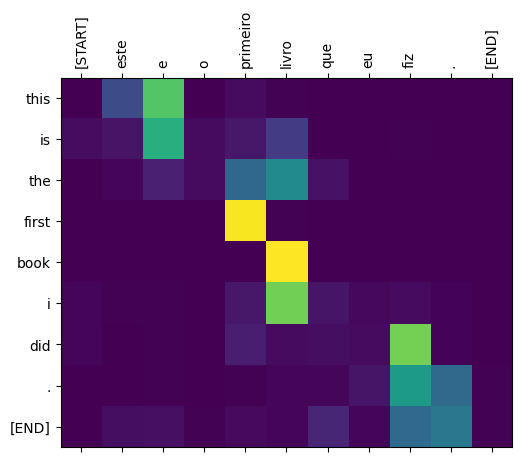

In [62]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [63]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

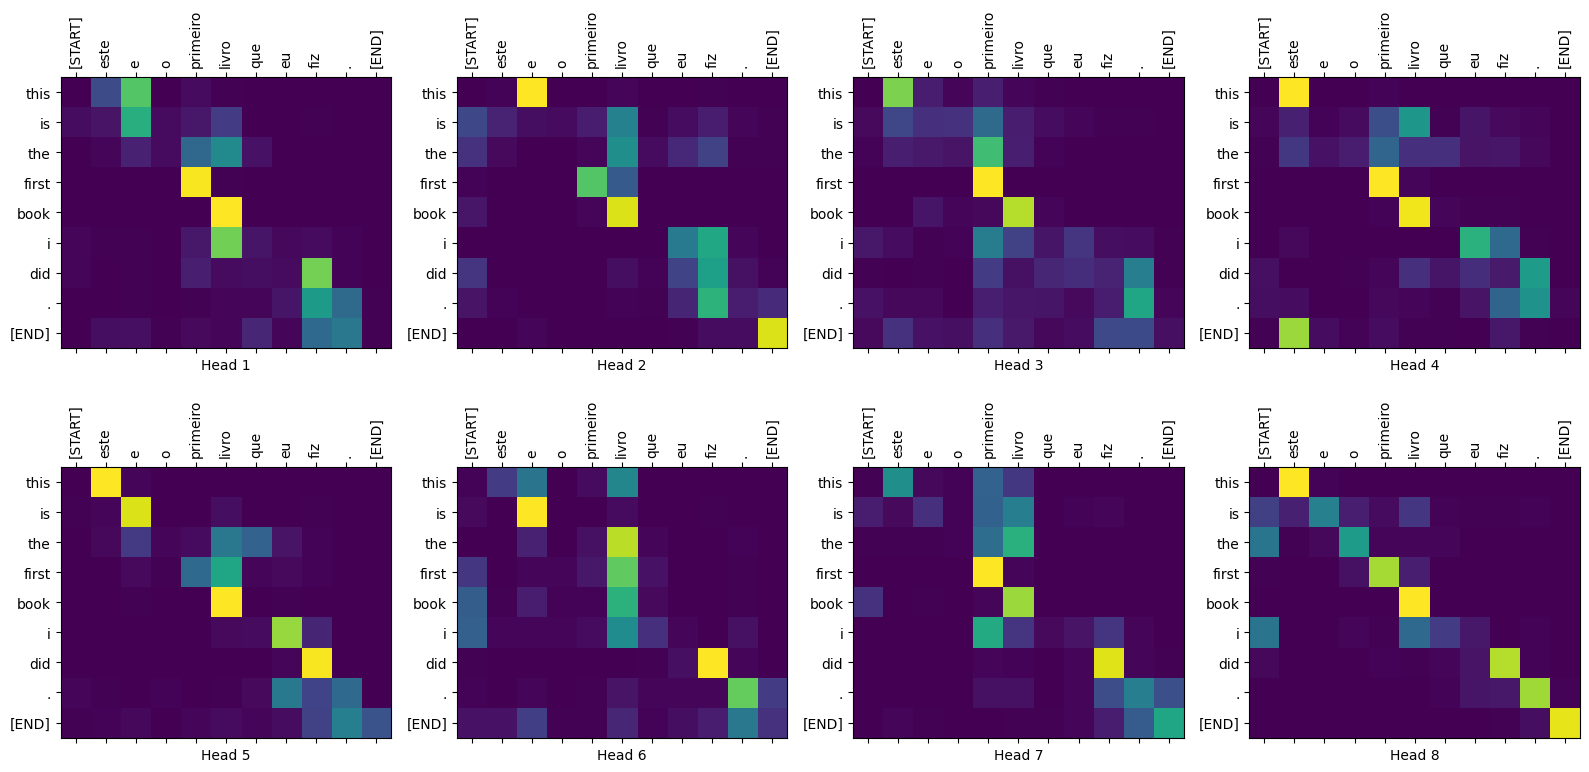

In [64]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

The model does okay on unfamiliar words. Neither `'triceratops'` nor `'encyclopédia'` are in the input dataset, and the model almost learns to transliterate them even without a shared vocabulary. For example:

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : i read about triumpes in egypt .
Ground truth   : I read about triceratops in the encyclopedia.


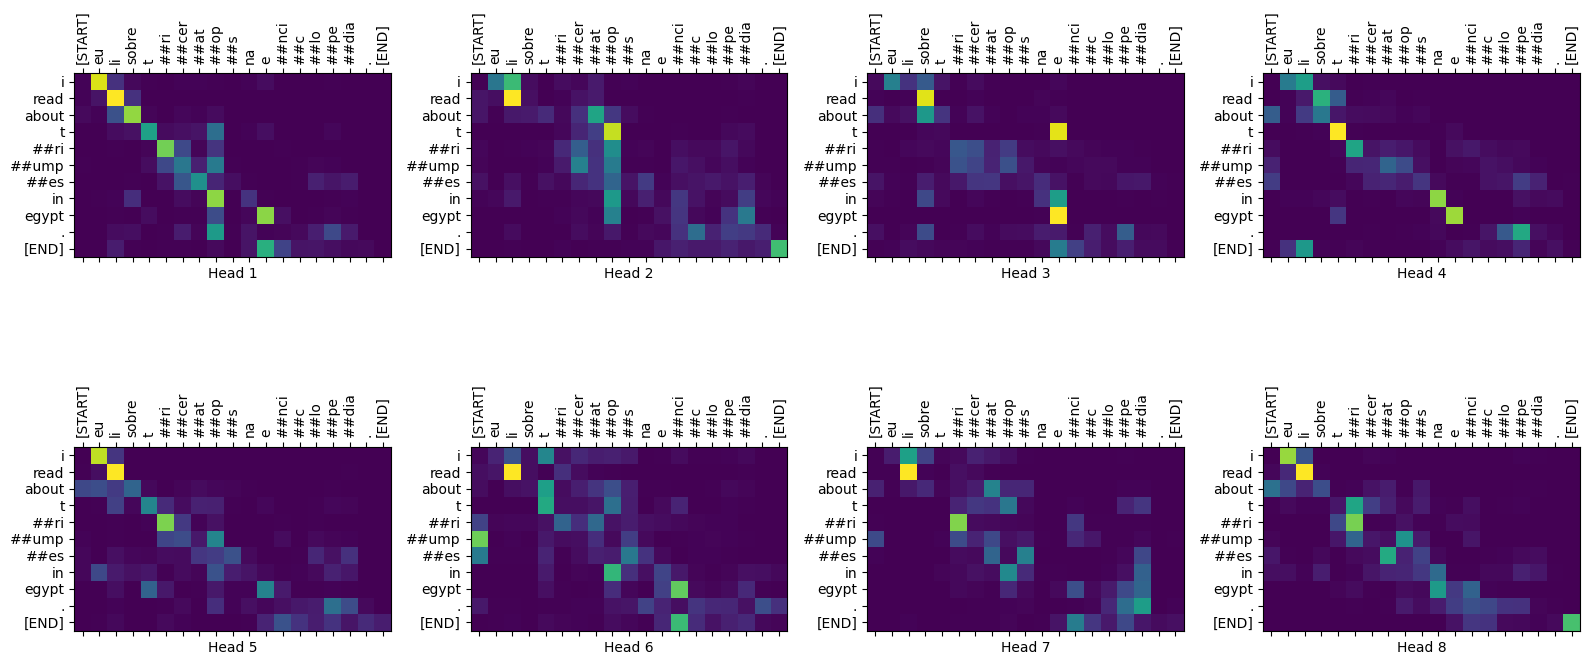

In [65]:
sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

## Export the model

You have tested the model and the inference is working. Next, you can export it as a `tf.saved_model`. To learn about saving and loading a model in the SavedModel format, use [this guide](https://www.tensorflow.org/guide/saved_model).

Create a class called `ExportTranslator` by subclassing the `tf.Module` subclass with a `tf.function` on the `__call__` method:

In [66]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In the above `tf.function` only the output sentence is returned. Thanks to the [non-strict execution](https://tensorflow.org/guide/intro_to_graphs) in `tf.function` any unnecessary values are never computed.

Wrap `translator` in the newly created `ExportTranslator`:

In [67]:
translator = ExportTranslator(translator)

Since the model is decoding the predictions using `tf.argmax` the predictions are deterministic. The original model and one reloaded from its `SavedModel` should give identical predictions:

In [68]:
translator('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i did .'

In [69]:
tf.saved_model.save(translator, export_dir='translator')

INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets


In [70]:
reloaded = tf.saved_model.load('translator')

In [71]:
reloaded('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i did .'

## Conclusion

In this tutorial you learned about:

* The Transformers and their significance in machine learning
* Attention, self-attention and multi-head attention
* Positional encoding with embeddings
* The encoder-decoder architecture of the original Transformer
* Masking in self-attention
* How to put it all together to translate text

The downsides of this architecture are:

- For a time-series, the output for a time-step is calculated from the *entire history* instead of only the inputs and current hidden-state. This _may_ be less efficient.
- If the input *does* have a  temporal/spatial relationship, like text, some positional encoding must be added or the model will effectively see a bag of words.

If you want to practice, there are many things you could try with it. For example:

* Use a different dataset to train the Transformer.
* Create the "Base Transformer" or "Transformer XL" configurations from the original paper by changing the hyperparameters.
* Use the layers defined here to create an implementation of [BERT](https://arxiv.org/abs/1810.04805){:.external}.
* Implement beam search to get better predictions.

There are a wide variety of Transformer-based models, many of which improve upon the 2017 version of the original Transformer with encoder-decoder, encoder-only and decoder-only architectures.

Some of these models are covered in the following research publications:

* ["Efficient Transformers: a survey"](https://arxiv.org/abs/2009.06732){:.external} (Tay et al., 2022)
* ["Formal algorithms for Transformers"](https://arxiv.org/abs/2207.09238){:.external} (Phuong and Hutter, 2022).
* [T5 ("Exploring the limits of transfer learning with a unified text-to-text Transformer")](https://arxiv.org/abs/1910.10683){:.external} (Raffel et al., 2019)

You can learn more about other models in the following Google blog posts:

* [PaLM](https://ai.googleblog.com/2022/04/pathways-language-model-palm-scaling-to.html){:.external}.
* [LaMDA](https://ai.googleblog.com/2022/01/lamda-towards-safe-grounded-and-high.html){:.external}
* [MUM](https://blog.google/products/search/introducing-mum/){:.external}
* [Reformer](https://ai.googleblog.com/2020/01/reformer-efficient-transformer.html){:.external}
* [BERT](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html){:.external}

If you're interested in studying how attention-based models have been applied in tasks outside of natural language processing, check out the following resources:

- Vision Transformer (ViT): [Transformers for image recognition at scale](https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html){:.external}
- [Multi-task multitrack music transcription (MT3)](https://magenta.tensorflow.org/transcription-with-transformers){:.external} with a Transformer
- [Code generation with AlphaCode](https://www.deepmind.com/blog/competitive-programming-with-alphacode){:.external}
- [Reinforcement learning with multi-game decision Transformers](https://ai.googleblog.com/2022/07/training-generalist-agents-with-multi.html){:.external}
- [Protein structure prediction with AlphaFold](https://www.nature.com/articles/s41586-021-03819-2){:.external}
- [OptFormer: Towards universal hyperparameter optimization with Transformers](http://ai.googleblog.com/2022/08/optformer-towards-universal.html){:.external}
